In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import torchvision.models as models

# Note: this notebook requires torch >= 1.10.0
torch.__version__
import os
import random
from PIL import Image
import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
!pip install torch torchvision torchaudio

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA A100-SXM4-40GB'

In [ ]:
!nvidia-smi

Tue Jun 18 15:07:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              45W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# IMAGE_FOLDER = "/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/160"

**Loading the Dataset**

In [5]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

image_path = "/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/"
walk_through_dir(image_path)

There are 5 directories and 0 images in '/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/'.
There are 2 directories and 0 images in '/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Train'.
There are 0 directories and 800 images in '/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Train/Normal'.
There are 0 directories and 800 images in '/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Train/Abnormal'.
There are 2 directories and 0 images in '/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Test'.
There are 0 directories and 200 images in '/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Test/Abnormal'.
There are 0 directories and 200 images in '/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Test/Normal'.
There are 3 directories and 0 images in '/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/160'.
There are 0 directories and 0 images in '/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/160/Ch

In [6]:
train_dir = "/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Train"
test_dir = "/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Test"
train_dir, test_dir

('/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Train',
 '/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Test')

**Understanding** **the** **Dataset**

Random image path: /content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Train/Normal/Normal-17728.png
Image class: Normal
Image height: 160
Image width: 160


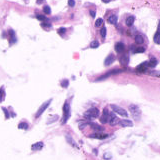

In [7]:
random.seed(42)

# 1. Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/*/*/*.png")

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

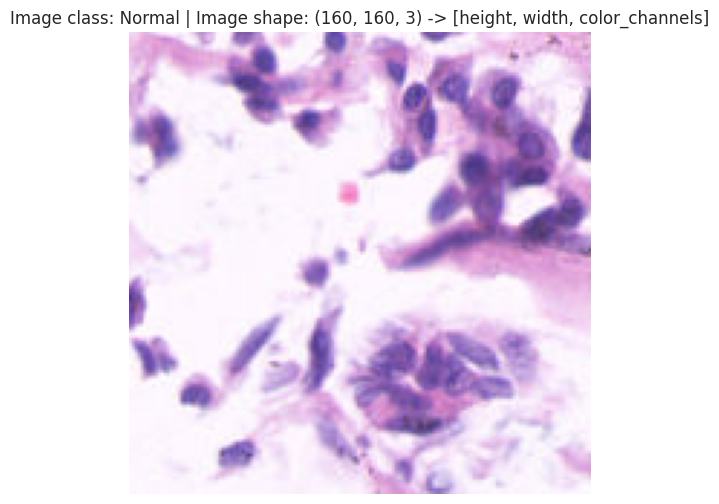

In [8]:
# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

**Transforming Data**

In [9]:
IMAGE_WIDTH=160
IMAGE_HEIGHT=160
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to IMAGE_SIZE xIMAGE_SIZE
    transforms.Resize(size=IMAGE_SIZE),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

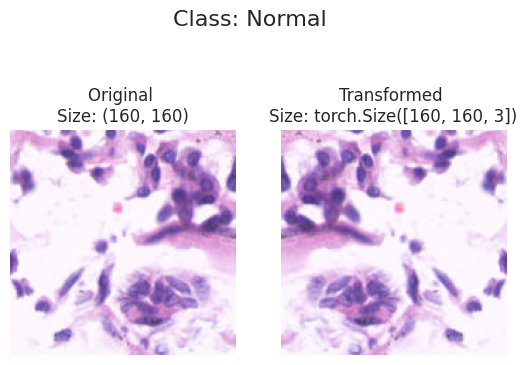

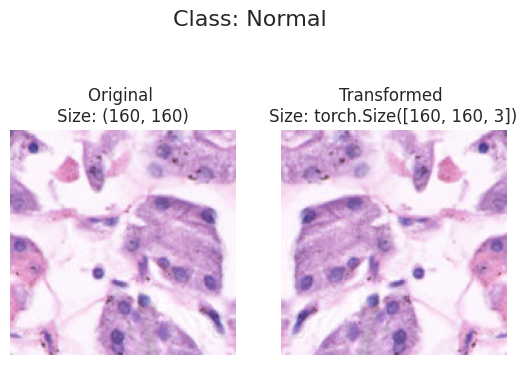

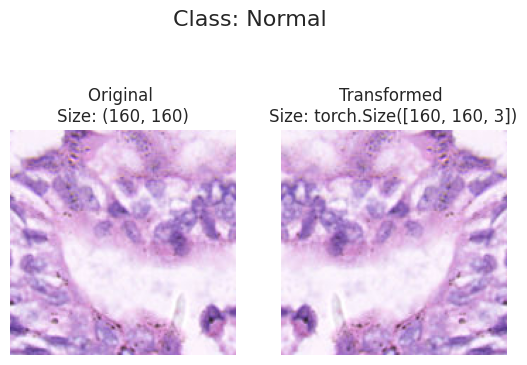

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(random_image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)


**Loading Image Data**

In [11]:
# Creating training set
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)
#Creating test set
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 1600
    Root location: /content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Train
    StandardTransform
Transform: Compose(
               Resize(size=(160, 160), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 400
    Root location: /content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Test
    StandardTransform
Transform: Compose(
               Resize(size=(160, 160), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [12]:
# Get class names as a list
class_names = train_data.classes
print("Class names: ",class_names)

# Can also get class names as a dict
class_dict = train_data.class_to_idx
print("Class names as a dict: ",class_dict)

# Check the lengths
print("The lengths of the training and test sets: ", len(train_data), len(test_data))

Class names:  ['Abnormal', 'Normal']
Class names as a dict:  {'Abnormal': 0, 'Normal': 1}
The lengths of the training and test sets:  1600 400


In [13]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.9804, 0.9569, 0.9412,  ..., 0.7059, 0.6667, 0.7020],
         [0.9686, 0.9333, 0.9294,  ..., 0.6627, 0.6157, 0.6627],
         [0.9686, 0.9294, 0.9333,  ..., 0.7176, 0.7176, 0.6941],
         ...,
         [0.7608, 0.7882, 0.8118,  ..., 0.8745, 0.9176, 0.9255],
         [0.8471, 0.8863, 0.8667,  ..., 0.9294, 1.0000, 0.9882],
         [0.7922, 0.8706, 0.8706,  ..., 0.9373, 1.0000, 0.9686]],

        [[0.6275, 0.6353, 0.6235,  ..., 0.5529, 0.5098, 0.5529],
         [0.6235, 0.6235, 0.6275,  ..., 0.4980, 0.4510, 0.4941],
         [0.6667, 0.6627, 0.6824,  ..., 0.5490, 0.5490, 0.5059],
         ...,
         [0.6000, 0.6235, 0.6392,  ..., 0.5765, 0.6196, 0.6549],
         [0.6745, 0.7137, 0.6824,  ..., 0.6588, 0.7333, 0.7725],
         [0.6118, 0.6863, 0.6784,  ..., 0.7098, 0.7804, 0.8039]],

        [[0.8706, 0.8784, 0.8549,  ..., 0.8157, 0.7843, 0.7922],
         [0.8510, 0.8471, 0.8471,  ..., 0.7804, 0.7412, 0.7725],
         [0.8706, 0.8627, 0.8784,  ..., 0.81

Original shape: torch.Size([3, 160, 160]) -> [color_channels, height, width]
Image permute shape: torch.Size([160, 160, 3]) -> [height, width, color_channels]


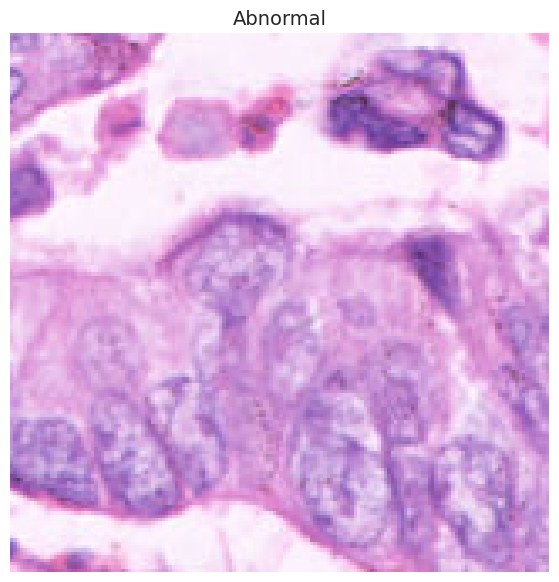

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

**Turn Loaded Images Into DataLoader's**

In [ ]:


# How many subprocesses will be used for data loading (higher = more)
NUM_WORKERS = os.cpu_count()  #used to get no.of cpus in the system

# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=NUM_WORKERS,
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=NUM_WORKERS,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b1b882be5f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b1b8806e1d0>)

In [ ]:
img, label = next(iter(train_dataloader))

# Note that batch size will now be 1.
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 160, 160]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


**Model Building With Data Augmentation**

In [ ]:
# Set image size.
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])

In [ ]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_augmented

(Dataset ImageFolder
     Number of datapoints: 1600
     Root location: /content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 400
     Root location: /content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
# Set some parameters.
BATCH_SIZE = 32
torch.manual_seed(42)

train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_data_augmented,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x7b1b88033400>,
 <torch.utils.data.dataloader.DataLoader at 0x7b1b880332e0>)

**Creating CNN Image Classifier**

In [ ]:
# # Creating a CNN-based image classifier.
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(64, 512, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(512),
          nn.MaxPool2d(2))
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=512*3*3, out_features=2))
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_3(x)
        x = self.classifier(x)
        return x
# Instantiate an object.

model1 = models.resnet34().to(device)
model = ImageClassifier().to(device)

**Try a forward pass on a single image (to test the model)**

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_augmented))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[-0.0059, -0.0123]], device='cuda:0')

Output prediction probabilities:
tensor([[0.5016, 0.4984]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
0


**Understanding the model**

In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
# do a test pass through of an example input size
summary(model, input_size=[1, 3, IMAGE_WIDTH ,IMAGE_HEIGHT])

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─BatchNorm2d: 2-3                  [1, 64, 224, 224]         128
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 512, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 512, 112, 112]        295,424
│    └─ReLU: 2-6                         [1, 512, 112, 112]        --
│    └─BatchNorm2d: 2-7                  [1, 512, 112, 112]        1,024
│    └─MaxPool2d: 2-8                    [1, 512, 56, 56]          --
├─Sequential: 1-3                        [1, 512, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 512, 56, 56]          2,359,

**Create train & test loop functions**

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:


# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

**Train and Evaluate Model**

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 25

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9189 | train_acc: 0.6369 | test_loss: 0.9143 | test_acc: 0.6490
Epoch: 2 | train_loss: 0.7534 | train_acc: 0.6850 | test_loss: 1.4507 | test_acc: 0.4856
Epoch: 3 | train_loss: 0.7798 | train_acc: 0.6750 | test_loss: 0.6471 | test_acc: 0.6923
Epoch: 4 | train_loss: 0.7323 | train_acc: 0.7119 | test_loss: 1.5263 | test_acc: 0.4952
Epoch: 5 | train_loss: 0.6916 | train_acc: 0.7037 | test_loss: 0.5343 | test_acc: 0.7380
Epoch: 6 | train_loss: 0.7864 | train_acc: 0.7106 | test_loss: 3.1367 | test_acc: 0.4832
Epoch: 7 | train_loss: 0.5969 | train_acc: 0.7394 | test_loss: 0.8868 | test_acc: 0.7668
Epoch: 8 | train_loss: 0.6947 | train_acc: 0.6925 | test_loss: 3.3143 | test_acc: 0.4808
Epoch: 9 | train_loss: 0.5750 | train_acc: 0.7419 | test_loss: 0.5032 | test_acc: 0.7716
Epoch: 10 | train_loss: 0.5373 | train_acc: 0.7500 | test_loss: 2.0744 | test_acc: 0.5144
Epoch: 11 | train_loss: 0.5299 | train_acc: 0.7650 | test_loss: 0.8900 | test_acc: 0.6899
Epoch: 12 | train_l

**Plot the loss curves of Model**

In [ ]:
def plot_loss_curves(results):

    results = dict(list(model_results.items()))

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='validation_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='validation_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

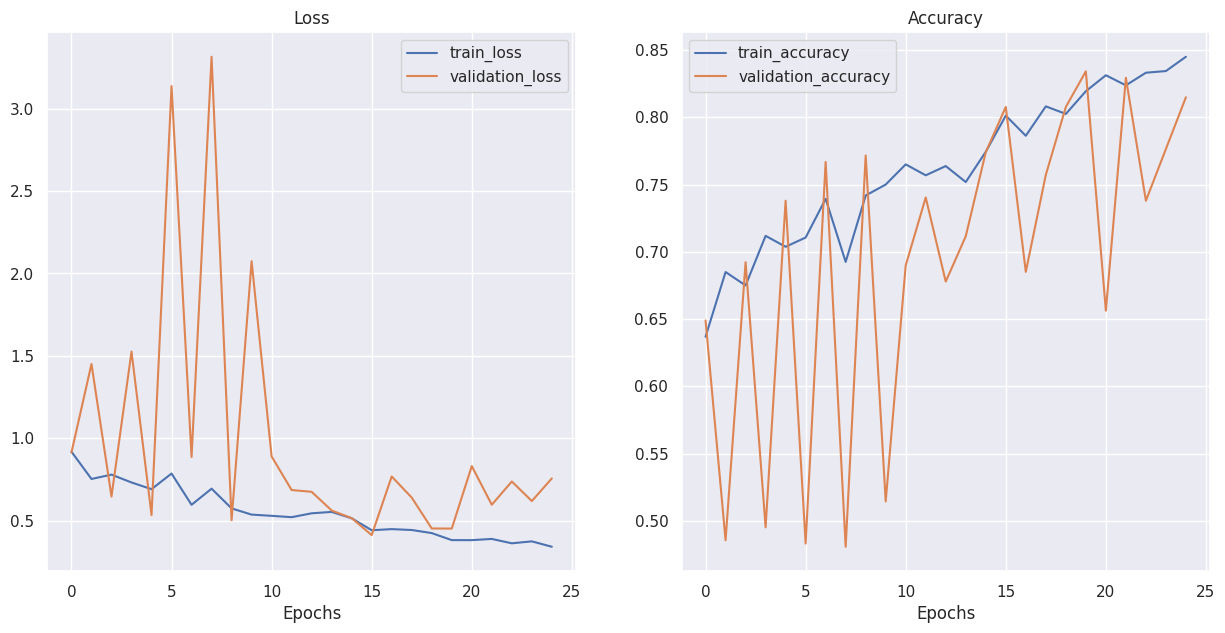

In [ ]:
plot_loss_curves(model_results)

**Make a Prediction**

In [ ]:
# Choose an image.
custom_image_path = "/content/gdrive/MyDrive/ResNet_implmentation_GasHisSDB/160/Test/Normal/Normal-18069.png"

# Load the image (you'll need to use a library like PIL or OpenCV)
from PIL import Image
custom_image = Image.open(custom_image_path)

# Convert to a NumPy array and divide pixel values
import numpy as np
custom_image = np.array(custom_image) / 160.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
[[[1.525   1.28125 1.475  ]
  [1.51875 1.2875  1.48125]
  [1.5125  1.2875  1.4625 ]
  ...
  [1.58125 1.44375 1.5875 ]
  [1.59375 1.5125  1.59375]
  [1.59375 1.5     1.59375]]

 [[1.54375 1.2375  1.4375 ]
  [1.55    1.26875 1.45   ]
  [1.5375  1.2875  1.45625]
  ...
  [1.59375 1.53125 1.59375]
  [1.59375 1.525   1.59375]
  [1.59375 1.5     1.59375]]

 [[1.55    1.2     1.44375]
  [1.56875 1.25625 1.475  ]
  [1.55625 1.3     1.4875 ]
  ...
  [1.59375 1.54375 1.59375]
  [1.5625  1.49375 1.59375]
  [1.54375 1.45    1.58125]]

 ...

 [[1.59375 1.55    1.59375]
  [1.59375 1.55    1.59375]
  [1.59375 1.55    1.59375]
  ...
  [1.5375  1.43125 1.53125]
  [1.575   1.53125 1.575  ]
  [1.59375 1.5875  1.59375]]

 [[1.59375 1.55    1.59375]
  [1.59375 1.55    1.59375]
  [1.59375 1.55    1.59375]
  ...
  [1.55    1.4625  1.56875]
  [1.55    1.50625 1.55   ]
  [1.59375 1.58125 1.59375]]

 [[1.59375 1.54375 1.59375]
  [1.59375 1.55625 1.59375]
  [1.59375 1.55625 1.59375]
  ...
  [

In [ ]:
!pip install pillow

import torch
from torchvision import transforms
from PIL import Image

# ... (rest of your code)

# Load the image using PIL
custom_image = Image.open(custom_image_path)

custom_image_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.size}") # Use .size for PIL Image
print(f"New shape: {custom_image_transformed.size}") # Use .size for PIL Image

Original shape: (160, 160)
New shape: (224, 224)


In [ ]:
model.eval()
with torch.inference_mode():
    # Convert PIL Image to PyTorch tensor
    custom_image_tensor = transforms.ToTensor()(custom_image_transformed).to(device)

    # Add an extra dimension to the tensor
    custom_image_transformed_with_batch_size = custom_image_tensor.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_tensor.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model(custom_image_transformed_with_batch_size) # Pass the tensor with batch dimension

Custom image transformed shape: torch.Size([3, 224, 224])
Unsqueezed custom image shape: torch.Size([1, 3, 224, 224])


In [ ]:
custom_image_pred

tensor([[-0.1379,  0.3461]], device='cuda:0')

In [ ]:
# Let's convert them from logits -> prediction probabilities -> prediction labels
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-0.1379,  0.3461]], device='cuda:0')
Prediction probabilities: tensor([[0.3813, 0.6187]], device='cuda:0')
Prediction label: tensor([1], device='cuda:0')


In [ ]:
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'Normal'

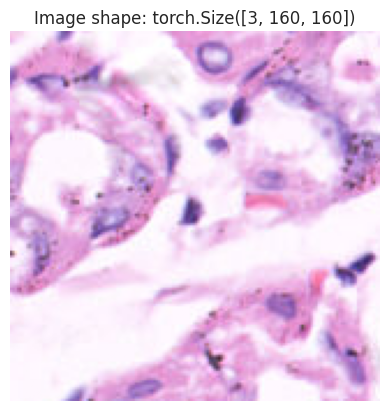

In [ ]:
# Convert the PIL Image to a PyTorch tensor
custom_image_tensor = transforms.ToTensor()(custom_image)

# Plot the image using the tensor
plt.imshow(custom_image_tensor.permute(1, 2, 0))  # Permute the tensor dimensions
plt.title(f"Image shape: {custom_image_tensor.shape}")
plt.axis(False);